<a href="https://colab.research.google.com/github/aisyahbil/alzheimer_classification/blob/main/CNN_Weight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00


In [ ]:
pip install torchsummary

In [ ]:
from datasets import load_dataset
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader

In [ ]:
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, GridSearchCV
from torch.nn import CrossEntropyLoss
from torch import optim, nn
from sklearn.model_selection import StratifiedKFold
from math import nextafter

In [ ]:
batch_size = 32

# Load your dataset using Hugging Face datasets
data_train = load_dataset('Falah/Alzheimer_MRI', split='train')
data_test = load_dataset('Falah/Alzheimer_MRI', split='test')

# Extract and preprocess the images and labels
array_train = [np.array(image) for image in data_train['image']]
array_test = [np.array(image) for image in data_test['image']]
array_train = np.array(array_train) / 255.0
array_test = np.array(array_test) / 255.0
array_train_label = np.array(data_train['label'])
array_test_label = np.array(data_test['label'])
array_train = np.stack((array_train,) * 3, axis=-1)  # Add 3 channels
array_test = np.stack((array_test,) * 3, axis=-1)    # Add 3 channels


# Convert NumPy arrays to PyTorch tensors
train_data = TensorDataset(torch.Tensor(array_train), torch.Tensor(array_train_label))
test_data = TensorDataset(torch.Tensor(array_test), torch.Tensor(array_test_label))

# Create DataLoader objects
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/5120 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1280 [00:00<?, ? examples/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Step 2: Define the CNN model
def create_model(hidden_size=512, dropout=0.2):
    model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Flatten(),

        nn.Linear(128 * 16 * 16, hidden_size),
        nn.ReLU(),
        nn.Dropout(dropout),

        nn.Linear(hidden_size, 4),
        nn.Softmax(dim=1)
    )
    # Store hyperparameters as attributes
    model.hidden_size = hidden_size
    model.dropout = dropout
    return model

In [ ]:
from torchsummary import summary


def determine_input_features(model):
    # Iterate through the layers to find the last linear layer
    for layer in reversed(model):
        if isinstance(layer, nn.Linear):
            return layer.in_features

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the model
model = create_model().to(device)

# Use torchsummary to print the model summary
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
              ReLU-2         [-1, 32, 128, 128]               0
         MaxPool2d-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
              ReLU-5           [-1, 64, 64, 64]               0
         MaxPool2d-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
              ReLU-8          [-1, 128, 32, 32]               0
         MaxPool2d-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 512]      16,777,728
             ReLU-12                  [-1, 512]               0
          Dropout-13                  [-1, 512]               0
           Linear-14                   

In [ ]:
# Define class weights (replace this with your actual class weights)
class_weights = [0.06377551, 0.89285714, 0.01785714, 0.0255102 ]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)#.to(create_model.device)


# Define the loss function with class weights
optimizer = optim.Adam(create_model().parameters(), lr=0.001)

#weight jumlah 1

In [ ]:
# Define the PyTorch classifier for scikit-learn compatibility

import copy
from itertools import product
from tqdm import tqdm  # Add this line
import torch.nn.functional as F

class PyTorchClassifierWrapper:
    def __init__(self, model, criterion, optimizer, epochs):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs


    def fit(self, X, y,class_weights_tensor):
        train_data = TensorDataset(torch.Tensor(X), torch.Tensor(y))
        trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

        for epoch in tqdm(range(self.epochs)):
            self.model.train()
            for inputs, labels in trainloader:
                inputs, labels = inputs.to(device), labels.long().to(device)

                self.optimizer.zero_grad()

                # Permute dimensions for PyTorch format
                inputs = inputs.permute(0, 3, 1, 2)

                outputs = self.model(inputs)
                if class_weights_tensor is not None:
                    loss = F.cross_entropy(outputs, labels, weight=class_weights_tensor)
                else:
                    loss = F.cross_entropy(outputs, labels)

                loss.backward()
                self.optimizer.step()

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            inputs = torch.Tensor(X).to(device)
            # Permute dimensions for PyTorch format
            inputs = inputs.permute(0, 3, 1, 2)
            outputs = self.model(inputs)
            _, preds = torch.max(outputs, 1)
        return preds.cpu().numpy()


# Set up hyperparameter search space
param_grid = {
    'hidden_size': [256, 512],
    'dropout': [0.2, 0.5]
}

# Use StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


best_model = None
best_accuracy = 0.0

for params in product(param_grid['hidden_size'], param_grid['dropout']):
    hidden_size, dropout = params
    model = create_model(hidden_size=hidden_size, dropout=dropout).to(device)
    wrapper = PyTorchClassifierWrapper(model, nn.CrossEntropyLoss(), optimizer, epochs=5)

    # Train and evaluate the model
    for train_index, val_index in skf.split(array_train, array_train_label):
        X_train, X_val = array_train[train_index], array_train[val_index]
        y_train, y_val = array_train_label[train_index], array_train_label[val_index]

        model = create_model().to(device)
        optimizer = optim.Adam(model.parameters())
        class_weights_tensor = class_weights_tensor.to(device)
        wrapper = PyTorchClassifierWrapper(model, nn.CrossEntropyLoss(weight=class_weights_tensor), optimizer, epochs=5)
        wrapper.fit(X_train, y_train, class_weights_tensor)
        predictions = wrapper.predict(X_val)
        accuracy = np.mean(predictions == y_val)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = copy.deepcopy(wrapper)

100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


In [ ]:
# Extract the best hyperparameters
best_hidden_size = best_model.model.hidden_size
best_dropout = best_model.model.dropout

print("Best Hyperparameters - Hidden Size: {}, Dropout: {}".format(best_hidden_size, best_dropout))
print("Best Validation Accuracy: ", best_accuracy)


Best Hyperparameters - Hidden Size: 512, Dropout: 0.2
Best Validation Accuracy:  0.6893317702227433


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Train the final model using the best hyperparameters on the entire training set
final_model = create_model(hidden_size=best_hidden_size, dropout=best_dropout).to(device)
final_optimizer = optim.Adam(final_model.parameters())  # Create optimizer for the final model
final_wrapper = PyTorchClassifierWrapper(final_model, nn.CrossEntropyLoss(), final_optimizer, epochs=10)

# Train on the entire training set
final_wrapper.fit(array_train, array_train_label,class_weights_tensor)

# Make predictions on the test set
test_predictions = final_wrapper.predict(array_test)
test_accuracy = np.mean(test_predictions == array_test_label)
precision = precision_score(array_test_label, test_predictions, average='weighted')
recall = recall_score(array_test_label, test_predictions, average='weighted')
f1 = f1_score(array_test_label, test_predictions, average='weighted')

print("Final Model Test Accuracy:", test_accuracy)
print("Final Model Precision:", precision)
print("Final Model Recall:", recall)
print("Final Model F1 Score:", f1)

100%|██████████| 10/10 [00:39<00:00,  3.97s/it]


Final Model Test Accuracy: 0.81171875
Final Model Precision: 0.8156731727254257
Final Model Recall: 0.81171875
Final Model F1 Score: 0.8126225591488471


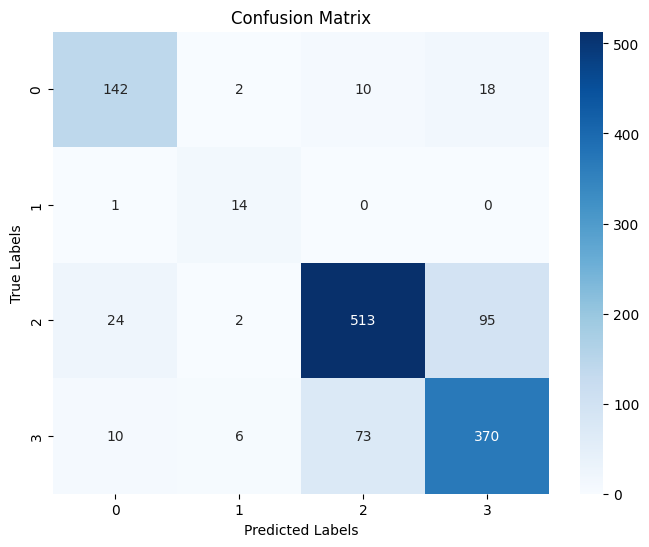

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix()
disp = ConfusionMatrixDisplay(array_test_label, test_predictions)
labels = ['0', '1', '2', '3']

conf_matrix = ConfusionMatrixDisplay(array_test_label, test_predictions)
class_labels = ['0', '1', '2', '3']  # Replace with your actual class labels


# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:
# Save the PyTorch model to Google Drive
torch.save(best_model.model.state_dict(), '/content/drive/MyDrive/cnn alzheimer/weight_model2.pth')

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms

# Define the model class
class YourModel(nn.Module):
    def __init__(self, hidden_size=512, dropout=0.2):
        super(YourModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),

            nn.Linear(128 * 16 * 16, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_size, 4),  # Adjust the number of output classes here
            nn.Softmax(dim=1)
        )
        # Store hyperparameters as attributes
        self.hidden_size = hidden_size
        self.dropout = dropout

    def forward(self, x):
        return self.model(x)

# Instantiate the model
model = YourModel()

# Load the model's state dictionary
model.load_state_dict(torch.load('/content/drive/MyDrive/cnn alzheimer/weight_model1.pth'))

# Set the model to evaluation mode
model.eval()

RuntimeError: Error(s) in loading state_dict for YourModel:
	Missing key(s) in state_dict: "model.0.weight", "model.0.bias", "model.3.weight", "model.3.bias", "model.6.weight", "model.6.bias", "model.10.weight", "model.10.bias", "model.13.weight", "model.13.bias". 
	Unexpected key(s) in state_dict: "0.weight", "0.bias", "3.weight", "3.bias", "6.weight", "6.bias", "10.weight", "10.bias", "13.weight", "13.bias". 

In [ ]:
# Load the model's state dictionary
state_dict = torch.load('/content/drive/MyDrive/cnn alzheimer/weight_model1.pth')

# Filter out keys that are not in the current model
state_dict = {k: v for k, v in state_dict.items() if k in model.state_dict()}

# Load the filtered state dictionary
model.load_state_dict(state_dict, strict=False)


_IncompatibleKeys(missing_keys=['model.0.weight', 'model.0.bias', 'model.3.weight', 'model.3.bias', 'model.6.weight', 'model.6.bias', 'model.10.weight', 'model.10.bias', 'model.13.weight', 'model.13.bias'], unexpected_keys=[])

In [ ]:
# Load the model's state dictionary
state_dict = torch.load('/content/drive/MyDrive/cnn alzheimer/weight_model1.pth')

# Print the keys
print(state_dict.keys())

odict_keys(['0.weight', '0.bias', '3.weight', '3.bias', '6.weight', '6.bias', '10.weight', '10.bias', '13.weight', '13.bias'])


In [ ]:
import torch
import torch.nn as nn

class YourModel(nn.Module):
    def __init__(self, hidden_size=512, dropout=0.2):
        super(YourModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),

            nn.Linear(128 * 16 * 16, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_size, 4),  # Adjust the number of output classes here
            nn.Softmax(dim=1)
        )
        # Store hyperparameters as attributes
        self.hidden_size = hidden_size
        self.dropout = dropout

    def forward(self, x):
        return self.model(x)

# Instantiate the modified model
model = YourModel()

# Load the state dictionary
state_dict = torch.load('/content/drive/MyDrive/cnn alzheimer/weight_model1.pth')

# Filter out keys that are not in the current model
state_dict = {k: v for k, v in state_dict.items() if k in model.state_dict()}

# Load the filtered state dictionary
model.load_state_dict(state_dict, strict=False)

# Set the model to evaluation mode
model.eval()


YourModel(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=32768, out_features=512, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.2, inplace=False)
    (13): Linear(in_features=512, out_features=4, bias=True)
    (14): Softmax(dim=1)
  )
)

In [ ]:
# Make predictions on the test set
# Convert NumPy array to PyTorch tensor
# Convert NumPy array to PyTorch tensor and transpose the channels

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

array_test_tensor = torch.tensor(array_test.transpose(0, 3, 1, 2), dtype=torch.float32).to(device)
# Move the model to the GPU (assuming device is 'cuda')
model = model.to(device)

# Make predictions on the test set
with torch.no_grad():
    test_predictions = model(array_test_tensor)
    _, test_predictions = torch.max(test_predictions, 1)

# Convert predictions to numpy array
test_predictions = test_predictions.cpu().numpy()

# Evaluate the model
test_accuracy = accuracy_score(array_test_label, test_predictions)
precision = precision_score(array_test_label, test_predictions, average='weighted')
recall = recall_score(array_test_label, test_predictions, average='weighted')
f1 = f1_score(array_test_label, test_predictions, average='weighted')

print("Final Model Test Accuracy:", test_accuracy)
print("Final Model Precision:", precision)
print("Final Model Recall:", recall)
print("Final Model F1 Score:", f1)

Final Model Test Accuracy: 0.45703125
Final Model Precision: 0.2534221839008288
Final Model Recall: 0.45703125
Final Model F1 Score: 0.3226095286292655


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#no weight

In [ ]:
# Define the PyTorch classifier for scikit-learn compatibility

import copy
from itertools import product
from tqdm import tqdm  # Add this line
import torch.nn.functional as F

class PyTorchClassifierWrapper:
    def __init__(self, model, criterion, optimizer, epochs):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs

    # def forward(self, x):
    #     return self.model(x)

    def fit(self, X, y):
        train_data = TensorDataset(torch.Tensor(X), torch.Tensor(y))
        trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

        for epoch in tqdm(range(self.epochs)):
            self.model.train()
            for inputs, labels in trainloader:
                inputs, labels = inputs.to(device), labels.long().to(device)

                self.optimizer.zero_grad()

                # Permute dimensions for PyTorch format
                inputs = inputs.permute(0, 3, 1, 2)

                outputs = self.model(inputs)
                loss = F.cross_entropy(outputs, labels)

                loss.backward()
                self.optimizer.step()

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            inputs = torch.Tensor(X).to(device)
            # Permute dimensions for PyTorch format
            inputs = inputs.permute(0, 3, 1, 2)
            outputs = self.model(inputs)
            _, preds = torch.max(outputs, 1)
        return preds.cpu().numpy()

    # def get_params(self, deep=True):
    #     return {'model': copy.deepcopy(self.model),
    #             'criterion': copy.deepcopy(self.criterion),
    #             'optimizer': copy.deepcopy(self.optimizer),
    #             'epochs': self.epochs
    #             }

# Set up hyperparameter search space
param_grid = {
    'hidden_size': [256, 512],
    'dropout': [0.2, 0.5]
}

# Use StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Wrap the PyTorch model in a scikit-learn compatible classifier
# model = create_model()
# pytorch_classifier = PyTorchClassifier(model, nn.CrossEntropyLoss(), optim.Adam(model.parameters()), epochs=5)

# Perform grid search with cross-validation
# Perform grid search with cross-validation
best_model = None
best_accuracy = 0.0

for params in product(param_grid['hidden_size'], param_grid['dropout']):
    hidden_size, dropout = params
    model = create_model(hidden_size=hidden_size, dropout=dropout).to(device)
    wrapper = PyTorchClassifierWrapper(model, nn.CrossEntropyLoss(), optimizer, epochs=5)

    # Train and evaluate the model
    for train_index, val_index in skf.split(array_train, array_train_label):
        X_train, X_val = array_train[train_index], array_train[val_index]
        y_train, y_val = array_train_label[train_index], array_train_label[val_index]

        #wrapper = PyTorchClassifierWrapper(model, nn.CrossEntropyLoss(weight=class_weights_tensor), optimizer, epochs=5)
        wrapper.fit(X_train, y_train)
        predictions = wrapper.predict(X_val)
        accuracy = np.mean(predictions == y_val)
        # wrapper = PyTorchClassifierWrapper(create_model(), optimizer, epochs=5)
        # wrapper.fit(X_train, y_train, class_weights_tensor)
        # predictions = wrapper.predict(X_val)
        # accuracy = np.mean(predictions == y_val)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = copy.deepcopy(wrapper)
# grid_search = GridSearchCV(estimator=pytorch_classifier, param_grid=param_grid, scoring='accuracy', cv=skf)
# grid_search.fit(array_train, array_train_label)

# Get the best hyperparameters
# best_params = grid_search.best_params_
# best_accuracy = grid_search.best_score_
# best_params = {'hidden_size': best_model.model[12].out_features, 'dropout': best_model.model[10].p}
# # Display the best hyperparameters and corresponding accuracy
# print("Best Accuracy: %f using %s" % (best_accuracy, best_params))

100%|██████████| 5/5 [00:10<00:00,  2.20s/it]


In [ ]:
# Extract the best hyperparameters
best_hidden_size = best_model.model.hidden_size
best_dropout = best_model.model.dropout

print("Best Hyperparameters - Hidden Size: {}, Dropout: {}".format(best_hidden_size, best_dropout))
print("Best Validation Accuracy: ", best_accuracy)


Best Hyperparameters - Hidden Size: 512, Dropout: 0.2
Best Validation Accuracy:  0.3481828839390387


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Train the final model using the best hyperparameters on the entire training set
final_model = create_model(hidden_size=best_hidden_size, dropout=best_dropout).to(device)
final_optimizer = optim.Adam(final_model.parameters())  # Create optimizer for the final model
final_wrapper = PyTorchClassifierWrapper(final_model, nn.CrossEntropyLoss(), final_optimizer, epochs=5)

# Train on the entire training set
final_wrapper.fit(array_train, array_train_label)

# Make predictions on the test set
test_predictions = final_wrapper.predict(array_test)
test_accuracy = np.mean(test_predictions == array_test_label)
precision = precision_score(array_test_label, test_predictions, average='weighted')
recall = recall_score(array_test_label, test_predictions, average='weighted')
f1 = f1_score(array_test_label, test_predictions, average='weighted')

print("Final Model Test Accuracy:", test_accuracy)
print("Final Model Precision:", precision)
print("Final Model Recall:", recall)
print("Final Model F1 Score:", f1)

100%|██████████| 5/5 [00:19<00:00,  3.98s/it]


Final Model Test Accuracy: 0.4953125
Final Model Precision: 0.24533447265625
Final Model Recall: 0.4953125
Final Model F1 Score: 0.3281380616509927


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


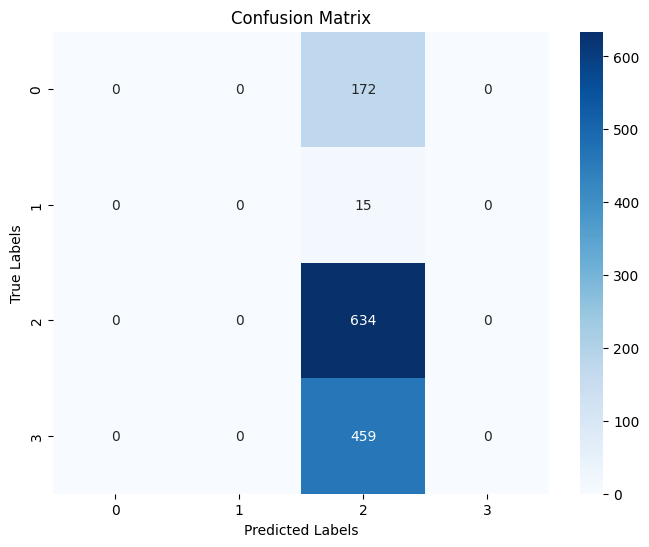

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
conf_matrix = confusion_matrix(array_test_label, test_predictions)
class_labels = ['0', '1', '2', '3']  # Replace with your actual class labels

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Save the PyTorch model to Google Drive
torch.save(best_model.model.state_dict(), '/content/drive/MyDrive/cnn alzheimer/no_weight.pth')

In [ ]:
model_weights_path = '/content/drive/MyDrive/path/to/save/model.pth'
model = create_model()  # Replace this with the actual model creation code
model.load_state_dict(torch.load(model_weights_path))

In [ ]:
# Instantiate the model with the same architecture
model1 = create_model(hidden_size=best_params['hidden_size'], dropout=best_params['dropout']).to(device)

# Load the saved weights
model1.load_state_dict(torch.load('/path/to/save/model.pth'))

# Set the model to evaluation mode
model1.eval()

# Now you can use this model for predictions on new data


NameError: name 'best_params' is not defined